라이브러리

In [14]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = ['Test230718_tank1_lstm_all', 'Test230717_tank1_lstm_crop_only-feed_no180', 'Test230721_tank1_lstm_crop720_only-feed']
lean_model_name = 'Test230721_tank1_lstm_3mult-input_lean2'

In [15]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [16]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [17]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [18]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [19]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [20]:
japonica_training_features_X_a = japonica_training_data[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_training_features_X_b = japonica_training_data[['feed_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X_a = japonica_validation_data[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_X_b = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [21]:
y_date = japonica_training_features_y.loc['2021-07-22 03:00':'2021-09-08 23:59']

y_train = np.asarray(y_date, dtype=np.float64)
y_train = y_train.reshape((-1, 1, 1))

y_train.shape

(63180, 1, 1)

In [22]:
X_test1 = japonica_training_features_X_a.loc['2021-07-22 00:00':'2021-09-08 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 351 nVar: 9
nCar: 351 nVar: 9


In [23]:
X_test2 = japonica_training_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 63180 nVar: 1
nCar: 63180 nVar: 1


In [24]:
X_test3 = japonica_training_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 88 nVar: 1
nCar: 88 nVar: 1


In [25]:
X_test_shape =[X_test_reshape1, X_test_reshape2, X_test_reshape3]

In [26]:
def X_pred(X_test_shape, y_test):
    X_pred = []
    model = []
    for i in range(len(model_name)):
        model.append(load_model(model_name[i]+'.h5', custom_objects={'r_squared': r_squared}))
        X_pred.append(model[i].predict(X_test_shape[i]))
        X_pred[i] = np.asarray(X_pred[i], dtype=np.float64)
        X_pred[i] = X_pred[i].reshape((-1))
        if len( X_pred[i]) > len(y_test):
            x = len( X_pred[i]) - len(y_test)
            X_pred[i] = X_pred[i][x:]
        print(i," : ",X_pred[i].shape)
    return np.array(X_pred)

In [27]:
def X_pred2(X_test_shape, y_test):
    X_pred = []
    model = []
    for i in range(len(model_name)):
        model.append(load_model(model_name[i]+'.h5', custom_objects={'r_squared': r_squared}))
        X_pred.append(model[i].predict(X_test_shape[i]))
        X_pred[i] = np.asarray(X_pred[i], dtype=np.float64)
        X_pred[i] = X_pred[i].reshape((-1))
        if len( X_pred[i]) > len(y_test):
            x = len( X_pred[i]) - len(y_test)
            X_pred[i] = X_pred[i][x:]
        print(i," : ",X_pred[i].shape)
        
    X_pred[1] = X_pred[1] / 8.50096798
    
    return np.array(X_pred)

In [32]:
feed = np.asarray(X_test2, dtype=np.float64)
feed = feed.reshape(-1)
X_train = np.vstack((X_pred(X_test_shape, y_train), feed)).T

X_train.shape

0  :  (63180,)
1  :  (63180,)
2  :  (63180,)


(63180, 4)

In [33]:
X_train = X_train.reshape((-1, 1, 4))

In [34]:
X_train.shape

(63180, 1, 4)

In [35]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-09-08 23:59']

y_test = np.asarray(y_date, dtype=np.float64)
y_test = y_test.reshape((-1, 1, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )


nCar: 63180 nVar: 1


In [36]:
X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-09-08 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 351 nVar: 9
nCar: 351 nVar: 9


In [37]:
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 63180 nVar: 1
nCar: 63180 nVar: 1


In [38]:
X_test3 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 88 nVar: 1
nCar: 88 nVar: 1


In [40]:
X_test_shape =[X_test_reshape1, X_test_reshape2, X_test_reshape3]
feed = np.asarray(X_test2, dtype=np.float64)
feed = feed.reshape(-1)
X_test = np.vstack((X_pred(X_test_shape, y_test), feed)).T
X_test = X_test.reshape((-1, 1, 4))
X_test.shape

0  :  (63180,)
1  :  (63180,)
2  :  (63180,)


(63180, 1, 4)

In [41]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(128, input_shape=(1, 4), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(lean_model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(X_train, y_train, epochs = 200, batch_size = 32, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(lean_model_name+'.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            68096     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 129,953
Trainable params: 129,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1975/1975 [==============================] - 37s 17ms/step - loss: 2.3905 - mae: 0.8727 - r_squared: -0.7686 - val_loss: 0.1446 - val_mae: 0.2701 - val_r_squared: -14221.3818
Epoch 2/200
1975/1975 [==============================] - 31s 

모델 평가

In [42]:


# 모델 평가 함수
def grapeNEva(model_name, X_test_shape, y_test, feed, y_test_shape):
    model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)
    
def grapeNEva4(y_test, X_test_shape, y_test_shape, feed):
    X_pred = []
    model = []
    for i in range(len(model_name)):
        model.append(load_model(model_name[i]+'.h5', custom_objects={'r_squared': r_squared}))
        X_pred.append(model[i].predict(X_test_shape[i]))
        X_pred[i] = np.asarray(X_pred[i], dtype=np.float64)
        X_pred[i] = X_pred[i].reshape((-1))
        print(len( X_pred[i]))
        if len( X_pred[i]) > len(y_test):
            x = len( X_pred[i]) - len(y_test)
            X_pred[i] = X_pred[i][x:]

        # 그래프 생성
        plt.figure(figsize=(15, 7))
        plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
        plt.plot(y_test.index, X_pred[i], color='red', label='prediction do')  # x축에 년월일, y축에 시분
        plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
        plt.xlabel('date')
        plt.ylabel('do')
        plt.title(model_name[i])
        plt.legend(['sensor do','prediction do','feed_quantity'])
        plt.show()
    
        # 평가 생성
        result = model[i].evaluate(X_test_shape[i], y_test_shape[i])
        print("MSE // MAE // R-squared ", result)
    
    
    final_predictions = (X_pred[0] + X_pred[1] + X_pred[2])/3
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('average')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    final_predictions = X_pred[0] * (X_pred[1] / 8.50096798)
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('multi')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, X_pred[1], label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred[2], color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('pred')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    final_predictions = ((X_pred[0] * (X_pred[1] / 8.50096798)) + X_pred[2])/2
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('multi')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()

    final_predictions = X_pred[0] * (X_pred[1] / 8.50096798) * (X_pred[2] / 8.50096798)
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('multi')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    final_predictions = (X_pred[1] / 8.50096798) * X_pred[2]
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('multi')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()

In [43]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-09-08 23:59']

y_test = y_date

y_test_reshape = np.asarray(y_date, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 1, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 63180 nVar: 1
nCar: 63180 nVar: 1


In [44]:
X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-09-08 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 351 nVar: 9
nCar: 351 nVar: 9


In [45]:
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 63180 nVar: 1
nCar: 63180 nVar: 1


In [46]:
X_test3 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 88 nVar: 1
nCar: 88 nVar: 1


In [49]:
X_test_shape =[X_test_reshape1, X_test_reshape2, X_test_reshape3]
feed = np.asarray(X_test2, dtype=np.float64)
feed = feed.reshape(-1)
X_test = np.vstack((X_pred(X_test_shape, y_test), feed)).T
X_test = X_test.reshape((-1, 1, 4))
X_test.shape

0  :  (63180,)
1  :  (63180,)
2  :  (63180,)


(63180, 1, 4)

63180


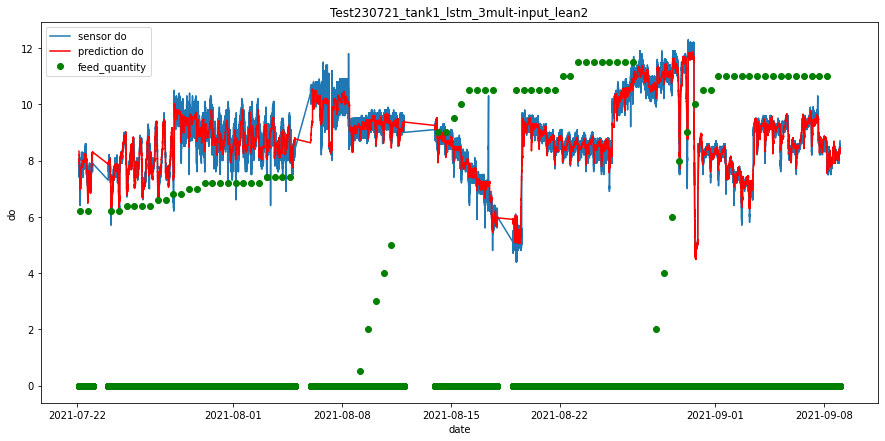

1975/1975 [==============================] - 14s 6ms/step - loss: 0.1196 - mae: 0.2449 - r_squared: -1256.5239
MSE // MAE // R-squared  [0.11959845572710037, 0.24489076435565948, -1256.52392578125]


In [50]:
grapeNEva(lean_model_name, X_test, y_test, X_test2[['feed_quantity']], y_test_reshape)

nCar: 12780 nVar: 1
nCar: 12780 nVar: 1
nCar: 71 nVar: 9
nCar: 71 nVar: 9
nCar: 12780 nVar: 1
nCar: 12780 nVar: 1
nCar: 18 nVar: 1
nCar: 18 nVar: 1
0  :  (12780,)
1  :  (12780,)
2  :  (12780,)
12780


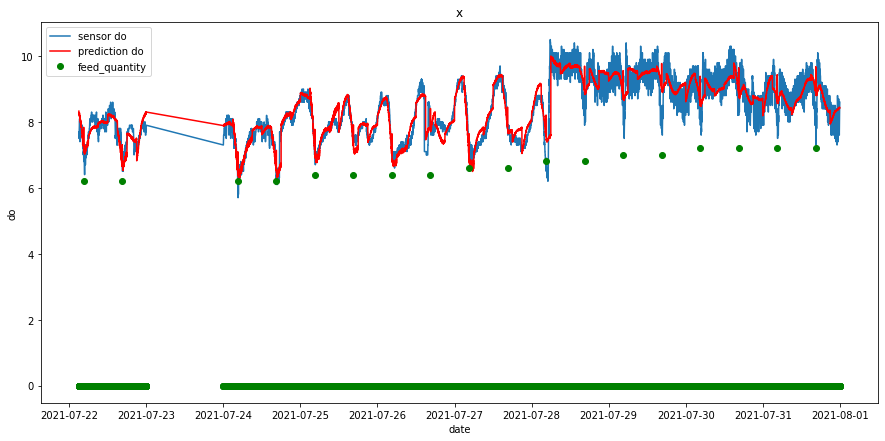

400/400 [==============================] - 4s 7ms/step - loss: 0.1341 - mae: 0.2663 - r_squared: -8.3477
MSE // MAE // R-squared  [0.13412027060985565, 0.2663275897502899, -8.347740173339844]


In [96]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-31 23:59']

y_test = y_date

y_test_reshape = np.asarray(y_date, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 1, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-31 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-31 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test3 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-31 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test_shape =[X_test_reshape1, X_test_reshape2, X_test_reshape3]
feed = np.asarray(X_test2, dtype=np.float64)
feed = feed.reshape(-1)
X_test = np.vstack((X_pred(X_test_shape, y_test), feed)).T
X_test = X_test.reshape((-1, 1, 4))
X_test.shape

grapeNEva(lean_model_name, X_test, y_test, X_test2[['feed_quantity']], y_test_reshape)

nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9
nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 2 nVar: 1
nCar: 2 nVar: 1
0  :  (1260,)
1  :  (1260,)
2  :  (1260,)
1260


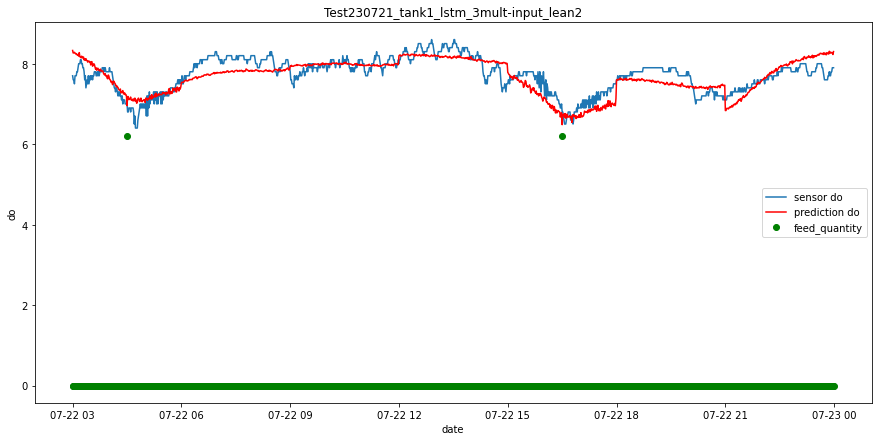

40/40 [==============================] - 1s 6ms/step - loss: 0.0706 - mae: 0.2198 - r_squared: -7.7330
MSE // MAE // R-squared  [0.07062581926584244, 0.2197761833667755, -7.732969760894775]


In [51]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-22 23:59']

y_test = y_date

y_test_reshape = np.asarray(y_date, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 1, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-22 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test3 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test_shape =[X_test_reshape1, X_test_reshape2, X_test_reshape3]
feed = np.asarray(X_test2, dtype=np.float64)
feed = feed.reshape(-1)
X_test = np.vstack((X_pred(X_test_shape, y_test), feed)).T
X_test = X_test.reshape((-1, 1, 4))
X_test.shape

grapeNEva(lean_model_name, X_test, y_test, X_test2[['feed_quantity']], y_test_reshape)

nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9
nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 2 nVar: 1
nCar: 2 nVar: 1


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


0  :  (1260,)
1  :  (1260,)
2  :  (1260,)
1260


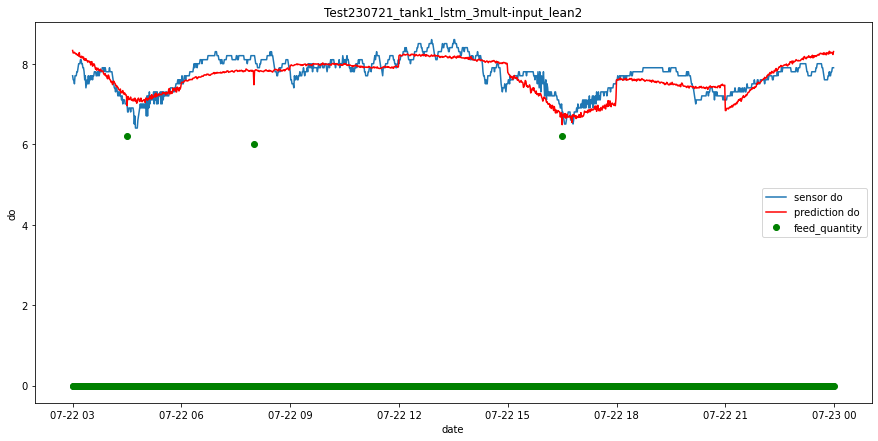

40/40 [==============================] - 1s 6ms/step - loss: 0.0715 - mae: 0.2216 - r_squared: -7.8002
MSE // MAE // R-squared  [0.07154327630996704, 0.22157815098762512, -7.800154685974121]


In [52]:
japonica_validation_features_X_a.at['2021-07-22 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-07-22 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-22 23:59']

y_test = y_date

y_test_reshape = np.asarray(y_date, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 1, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-22 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test3 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test_shape =[X_test_reshape1, X_test_reshape2, X_test_reshape3]
feed = np.asarray(X_test2, dtype=np.float64)
feed = feed.reshape(-1)
X_test = np.vstack((X_pred(X_test_shape, y_test), feed)).T
X_test = X_test.reshape((-1, 1, 4))
X_test.shape

grapeNEva(lean_model_name, X_test, y_test, X_test2[['feed_quantity']], y_test_reshape)

nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9
nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 2 nVar: 1
nCar: 2 nVar: 1
0  :  (1260,)
1  :  (1260,)
2  :  (1260,)
1260


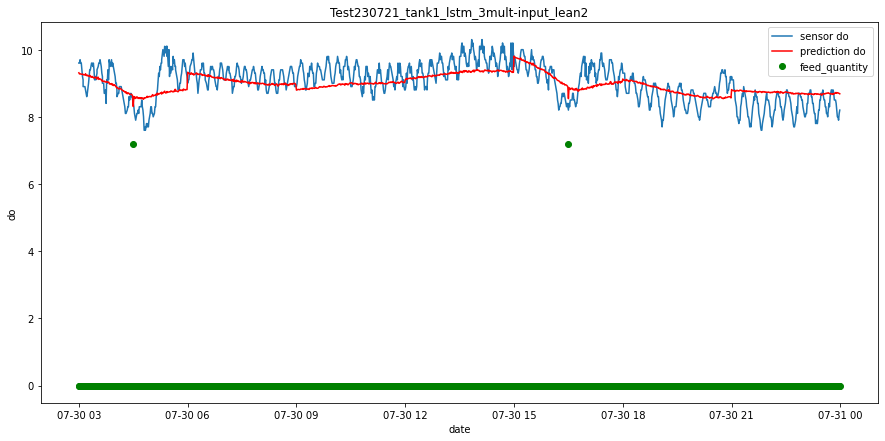

40/40 [==============================] - 1s 7ms/step - loss: 0.1939 - mae: 0.3550 - r_squared: -1.3328
MSE // MAE // R-squared  [0.1939198523759842, 0.35496875643730164, -1.3327933549880981]


In [53]:
y_date = japonica_validation_features_y.loc['2021-07-30 03:00':'2021-07-30 23:59']

y_test = y_date

y_test_reshape = np.asarray(y_date, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 1, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-30 00:00':'2021-07-30 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test2 = japonica_validation_features_X_b.loc['2021-07-30 03:00':'2021-07-30 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test3 = japonica_validation_features_X_b.loc['2021-07-30 03:00':'2021-07-30 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test_shape =[X_test_reshape1, X_test_reshape2, X_test_reshape3]
feed = np.asarray(X_test2, dtype=np.float64)
feed = feed.reshape(-1)
X_test = np.vstack((X_pred(X_test_shape, y_test), feed)).T
X_test = X_test.reshape((-1, 1, 4))
X_test.shape

grapeNEva(lean_model_name, X_test, y_test, X_test2[['feed_quantity']], y_test_reshape)

nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9
nCar: 1260 nVar: 1
nCar: 1260 nVar: 1
nCar: 2 nVar: 1
nCar: 2 nVar: 1


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


0  :  (1260,)
1  :  (1260,)
2  :  (1260,)
1260


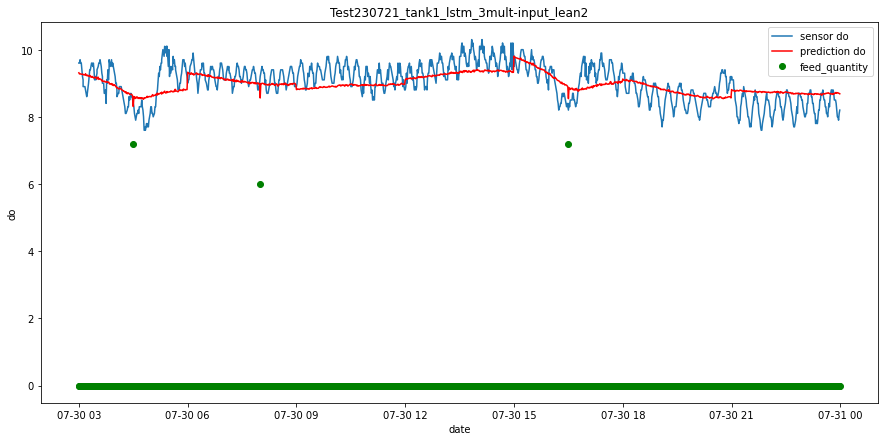

40/40 [==============================] - 1s 3ms/step - loss: 0.1962 - mae: 0.3577 - r_squared: -1.3658
MSE // MAE // R-squared  [0.19617284834384918, 0.35766229033470154, -1.3657536506652832]


In [54]:
japonica_validation_features_X_a.at['2021-07-30 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-07-30 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-07-30 03:00':'2021-07-30 23:59']

y_test = y_date

y_test_reshape = np.asarray(y_date, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 1, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-30 00:00':'2021-07-30 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test2 = japonica_validation_features_X_b.loc['2021-07-30 03:00':'2021-07-30 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test3 = japonica_validation_features_X_b.loc['2021-07-30 03:00':'2021-07-30 23:59']

X_test_reshape3 = np.asarray(X_test3, dtype=np.float64)
zero_padding = np.zeros((180, 1), dtype=np.float64)
X_test_reshape3 = np.concatenate([zero_padding, X_test_reshape3], axis=0)
X_test_reshape3 = X_test_reshape3.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape3.shape[0] # 데이터 개수
nVar = X_test_reshape3.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test_shape =[X_test_reshape1, X_test_reshape2, X_test_reshape3]
feed = np.asarray(X_test2, dtype=np.float64)
feed = feed.reshape(-1)
X_test = np.vstack((X_pred(X_test_shape, y_test), feed)).T
X_test = X_test.reshape((-1, 1, 4))
X_test.shape

grapeNEva(lean_model_name, X_test, y_test, X_test2[['feed_quantity']], y_test_reshape)